In [59]:
from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import segmentation_models_pytorch as smp

import model
import metrics
import config

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config
import glob

In [60]:
# Paths
IMAGES_PATH = r'..\data\patches\images\1942'
MASK_PATH = r'..\data\patches\masks\1942'

image_paths = glob.glob(IMAGES_PATH +'\*.tif')
mask_paths = glob.glob(MASK_PATH +'\*.tif')

### Dataloader

In [61]:
# Dataset Object 
print('Number of image patches:', len(image_paths),'\nNumber of mask patches:', len(mask_paths))
dataset = HistoricalImagesDataset(image_paths, mask_paths)
data = next(iter(dataset))
print('shape image', data[0].shape, 'shape mask', data[1].shape)       

# Train, Test, Split -- DEVEOLP A SPLITTING STRATEGY BASED ON THE SPATIAL INFORMATION !!!!!!!!!
print('Splitting data into TRAIN, VAL and TEST')
train_size = int(0.02 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

train_size = int(0.5 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE)
# print("Testing set size: ", len(test_dataset))
# test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

Number of image patches: 858 
Number of mask patches: 858
shape image torch.Size([1, 512, 512]) shape mask torch.Size([1, 512, 512])
Splitting data into TRAIN, VAL and TEST
Training set size:  8
Validation set size:  9



### Model

In [84]:
unet_model = smp.Unet(
    encoder_name= config.BACKBONE,  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=config.N_CHANNELS,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes= config.N_CLASSES,    # model output channels (number of classes in your dataset)
)

### Loss, Optmization, Number of Iterations

In [63]:
# Initialize our model
model = unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = optim.Adam(model.parameters(), lr=config.LR)

# calculate steps per epoch for training and test set
trainSteps = len(train_dataset) // config.BATCH_SIZE
valSteps = len(val_dataset) // config.BATCH_SIZE

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": []}

# initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": []}

In [90]:
import torch.nn as nn
print(unet_model)
fc = nn.Sequential(nn.Linear(in_features=32, out_features=1, bias=True), nn.Sigmoid()) # 512 neurons, 2 classes
model.fc = fc

model.fc

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

Sequential(
  (0): Linear(in_features=32, out_features=1, bias=True)
  (1): Sigmoid()
)

### Training

In [91]:
# Training the network 
print('Training the network...🤗')
for e in tqdm(range(5)):
    # set the model in training mode
    model.train()

    # For each epoch initialize the: 
    # total training
    totalTrainLoss = 0
    totalValLoss = 0

    # number of correctly classified pixels and the total number of pixels
    train_correct = 0
    total_n_pixels = 0

    # loop over the training set
    loop = tqdm(train_dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)
        
        opt.zero_grad()  # zero out any previously accumulated gradients
        loss.backward() # obtain the gradients with respect to the loss
        opt.step() # perform one step of gradient descendent
        totalTrainLoss += loss  # add the loss to the total training loss so far
        
        
    # switch off autograd
    with torch.no_grad():
    # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x_val, y_val) in val_dataloader:
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            print(loss)

    # calculate the average training and validation loss PER EPOCH
    avgTrainLoss = totalTrainLoss / trainSteps 
    avgValLoss = totalValLoss / valSteps
    
    print(f'avg train loss {avgTrainLoss}')
    print('val loss', avgValLoss)

    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss

    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))

print(training_history)
print(validation_history)

Training the network...🤗


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.0301)
tensor(0.1020)


 20%|██        | 1/5 [00:17<01:10, 17.61s/it]

tensor(0.1756)
avg train loss 0.013921799138188362
val loss tensor(0.1539)
[INFO] EPOCH: 1/2


tensor(0.0140)
tensor(0.0471)


 40%|████      | 2/5 [00:34<00:52, 17.40s/it]

tensor(0.0794)
avg train loss 0.009077801369130611
val loss tensor(0.0703)
[INFO] EPOCH: 2/2


tensor(0.0067)
tensor(0.0219)


 60%|██████    | 3/5 [00:51<00:34, 17.11s/it]

tensor(0.0368)
avg train loss 0.007229072041809559
val loss tensor(0.0327)
[INFO] EPOCH: 3/2


tensor(0.0043)
tensor(0.0120)


 80%|████████  | 4/5 [01:08<00:17, 17.09s/it]

tensor(0.0201)
avg train loss 0.006367039401084185
val loss tensor(0.0182)
[INFO] EPOCH: 4/2


tensor(0.0038)
tensor(0.0084)


100%|██████████| 5/5 [01:26<00:00, 17.28s/it]

tensor(0.0148)
avg train loss 0.0059889862313866615
val loss tensor(0.0135)
[INFO] EPOCH: 5/2
{'avg_train_loss': [array(0.90467644, dtype=float32), array(0.4554322, dtype=float32), array(0.18268591, dtype=float32), array(0.06770437, dtype=float32), array(0.02665778, dtype=float32), array(0.0139218, dtype=float32), array(0.0090778, dtype=float32), array(0.00722907, dtype=float32), array(0.00636704, dtype=float32), array(0.00598899, dtype=float32)], 'train_accuracy': []}
{'avg_val_loss': [array(3622.6348, dtype=float32), array(53.6239, dtype=float32), array(3.375298, dtype=float32), array(0.8140429, dtype=float32), array(0.3576891, dtype=float32), array(0.15386741, dtype=float32), array(0.07028741, dtype=float32), array(0.03271876, dtype=float32), array(0.01816257, dtype=float32), array(0.01350026, dtype=float32)], 'val_accuracy': []}


In [94]:
validation_history['avg_val_loss']

[array(3622.6348, dtype=float32),
 array(53.6239, dtype=float32),
 array(3.375298, dtype=float32),
 array(0.8140429, dtype=float32),
 array(0.3576891, dtype=float32),
 array(0.15386741, dtype=float32),
 array(0.07028741, dtype=float32),
 array(0.03271876, dtype=float32),
 array(0.01816257, dtype=float32),
 array(0.01350026, dtype=float32)]

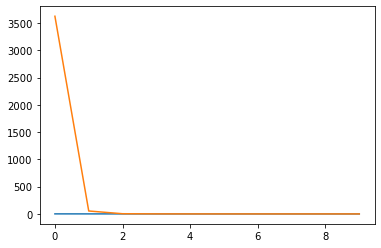

In [93]:
plt.figure()
plt.plot(training_history['avg_train_loss'])
plt.plot(validation_history['avg_val_loss'])